## QuickTest Slim

based on : RankNet-QuickTest-Joint

    makedb laptime
    makedb gluonts
    train model
    evaluate model


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import random
import mxnet as mx
from mxnet import gluon
import pickle
import json
import copy
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from pathlib import Path
import configparser

from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.trainer import Trainer
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.model.predictor import Predictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.r_forecast import RForecastPredictor
from gluonts.dataset.util import to_pandas

from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.distribution.student_t import StudentTOutput
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput

from indycar.model.NaivePredictor import NaivePredictor
from indycar.model.deeparw import DeepARWeightEstimator

#import indycar.model.stint_simulator_shortterm_pitmodel as stint
import indycar.model.quicktest_simulator as stint

# import all functions 
#from indycar.model.global_variables import _hi
import indycar.model.global_variables as gvar
from indycar.model.quicktest_modules import *

INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU


## run

In [2]:
experimentid = 'weighted-noinlap-S0LTYP0T-nocate-c60-poconotf'


WorkRootDir = 'QuickTestOutput'
configfile = f'config/weighted-noinlap-S0LTYP0T-nocate-c60-drank-pitmodel.ini'

if not os.path.exists(configfile):
    print('config file not exists error:', configfile)
    sys.exit(-1)

if configfile != '':
    config = configparser.RawConfigParser()
    config.read(configfile)

    #set them back
    section = "RankNet-QuickTest"
    
    _savedata = config.getboolean(section, "_savedata")
    _skip_overwrite = config.getboolean(section, "_skip_overwrite")
    _inlap_status = config.getint(section, "_inlap_status") #0
    _feature_mode = config.getint(section, "_feature_mode") #FEATURE_STATUS
    _featureCnt = config.getint(section, "_featureCnt") #9
    freq = config.get(section, "freq") #"1min"
    _train_len = config.getint(section, "_train_len") #40
    prediction_length = config.getint(section, "prediction_length") #2
    context_ratio = config.getfloat(section, "context_ratio") #0.
    context_length =  config.getint(section, "context_length") #40
    
    dataset= config.get(section, "dataset") #'rank'
    epochs = config.getint(section, "epochs") #1000
    gpuid = config.getint(section, "gpuid") #5
    _use_weighted_model = config.getboolean(section, "_use_weighted_model")
    trainmodel = config.get(section, "trainmodel") #'deepARW-Oracle' if _use_weighted_model else 'deepAR-Oracle'
    
    _use_cate_feature = config.getboolean(section, "_use_cate_feature")
    
    distroutput = config.get(section, "distroutput") #'student'
    batch_size = config.getint(section, "batch_size") #32
    loopcnt = config.getint(section, "loopcnt") #2
    _test_event = config.get(section, "_test_event") #'Indy500-2018'
    testmodel = config.get(section, "testmodel") #'oracle'
    pitmodel = config.get(section, "pitmodel") #'oracle'
    year = config.get(section, "year") #'2018'
    
    contextlen = context_length
    use_feat_static = _use_cate_feature 

    #config1 = get_config()
    train_years = config.get(section, "train_years", fallback='2013,2014,2015,2016,2017')
    _train_years = train_years.split(',')
    
else:
    print('Warning, please use config file')
    sys.exit(0)


# In[3]:
# new added parameters
_draw_figs = True
_test_train_len = 40
_joint_train = False
_pitmodel_bias = 0
#shortterm, stint
#_forecast_mode = 'stint'
_forecast_mode = 'shortterm'


dataroot = 'data/'
trainrace = 'Pocono'
_test_event = 'Pocono-2018'

trainmodel = 'deepARW-Oracle'
testmodel = 'deepARW-MLP'

trainmodel = 'TransformerWFM-Oracle'
testmodel = 'TransformerWFM-MLP'

#discard year
year = _test_event

if testmodel == 'pitmodel':
    testmodel = 'pitmodel%s'%(_pitmodel_bias if _pitmodel_bias!=0 else '')

cur_featurestr = decode_feature_mode(_feature_mode)

#
# string map
#
inlapstr = {0:'noinlap',1:'inlap',2:'outlap'}
weightstr = {True:'weighted',False:'noweighted'}
catestr = {True:'cate',False:'nocate'}

#
# input data parameters
#
# event -> car#, maxlap
events_info = {
        'Phoenix':(256, 1.022, 250),'Indy500':(500,2.5,200),'Texas':(372,1.5,248),
        'Iowa':(268,0.894,300),'Pocono':(500,2.5,200),'Gateway':(310,1.25,248)
}
_race_info = {}
# the races have 7 years data 
races = ['Indy500', 'Texas','Iowa','Pocono']
years = ['2013','2014','2015','2016','2017','2018','2019']

events = []
for race in races:
    events.extend([f'{race}-{x}' for x in years])

events.extend(['Phoenix-2018','Gateway-2018','Gateway-2019'])
events_id={key:idx for idx, key in enumerate(events)}

# dataset shared
dataOutputRoot = "data/"
covergap = 1
dbid = f'IndyCar_d{len(events)}_v{_featureCnt}_p{_inlap_status}'
LAPTIME_DATASET = f'{dataOutputRoot}/laptime_rank_timediff_pit-oracle-{dbid}.pickle' 
STAGE_DATASET = f'{dataOutputRoot}/stagedata-{dbid}.pickle' 
PITCOVERED_DATASET = f'{dataOutputRoot}/pitcoveredlaps-{dbid}-g{covergap}.pickle' 

#dbid = f'Indy500_{years[0]}_{years[-1]}_v{_featureCnt}_p{_inlap_status}'
dbid = f'IndyCar_d{len(events)}_v{_featureCnt}_p{_inlap_status}'
_dataset_id = '%s-%s'%(inlapstr[_inlap_status], cur_featurestr)

#trainrace = 'Indy500'
#_train_events = [events_id[x] for x in [f'{trainrace}-{x}' for x in ['2013','2014','2015','2016','2017']]]

#patch
if trainrace == 'Pocono':
    _train_years = ['2013','2015','2016','2017']

_train_events = [events_id[x] for x in [f'{trainrace}-{x}' for x in _train_years]]
#replace TRAINRACE in pitmodel
if pitmodel.find('TRAINRACE') > 0:
    pitmodel = pitmodel.replace('TRAINRACE', trainrace)


#
# internal parameters
#
distr_outputs ={'student':StudentTOutput(),
                'negbin':NegativeBinomialOutput()
                }
distr_output = distr_outputs[distroutput]

#
#
#
#experimentid = f'{weightstr[_use_weighted_model]}-{inlapstr[_inlap_status]}-{cur_featurestr}-{catestr[_use_cate_feature]}-c{context_length}{_debugstr}'

#
#
#
outputRoot = f"{WorkRootDir}/{experimentid}/"
#version = f'IndyCar-d{len(events)}-endlap'
version = f'IndyCar-d{trainrace}-endlap'

# standard output file names
SIMULATION_OUTFILE = f'{outputRoot}/{_test_event}/{_forecast_mode}-dfout-{trainmodel}-indy500-{dataset}-{inlapstr[_inlap_status]}-{cur_featurestr}-{testmodel}-l{loopcnt}-alldata.pickle'
EVALUATION_RESULT_DF = f'{outputRoot}/{_test_event}/{_forecast_mode}-evaluation_result_d{dataset}_m{testmodel}.csv'
LONG_FORECASTING_DFS = f'{outputRoot}/{_test_event}/{_forecast_mode}-long_forecasting_dfs_d{dataset}_m{testmodel}.pickle'
FORECAST_FIGS_DIR = f'{outputRoot}/{_test_event}/{_forecast_mode}-forecast-figs-d{dataset}_m{testmodel}/'


# In[5]:


# set global vars
gvar._savedata =                            _savedata
gvar._skip_overwrite =                      _skip_overwrite
gvar._inlap_status =                        _inlap_status
gvar._feature_mode =                        _feature_mode
gvar._featureCnt =                          _featureCnt
gvar.freq  =                                freq 
gvar._train_len =                           _train_len
gvar.prediction_length =                    prediction_length
gvar.context_ratio =                        context_ratio
gvar.context_length =                       context_length
gvar.contextlen =                           contextlen
gvar.dataset =                              dataset
gvar.epochs =                               epochs
gvar.gpuid =                                gpuid
gvar._use_weighted_model =                  _use_weighted_model
gvar.trainmodel =                           trainmodel
gvar._use_cate_feature =                    _use_cate_feature
gvar.use_feat_static =                      use_feat_static
gvar.distroutput =                          distroutput
gvar.batch_size =                           batch_size
gvar.loopcnt =                              loopcnt
gvar._test_event =                          _test_event
gvar.testmodel =                            testmodel
gvar.pitmodel =                             pitmodel
gvar.year =                                year
gvar._forecast_mode = _forecast_mode
gvar._test_train_len = _test_train_len
gvar._joint_train = _joint_train
gvar._pitmodel_bias = _pitmodel_bias
gvar._train_events = _train_events

gvar.dbid = dbid
gvar.LAPTIME_DATASET = LAPTIME_DATASET


# ### 1. make laptime dataset

# In[6]:


stagedata = {}
global_carids = {}
os.makedirs(outputRoot, exist_ok=True)
os.makedirs(f'{outputRoot}/{_test_event}', exist_ok=True)

#check the dest files first

#
# load data
#
print('Load laptime and stage dataset:',LAPTIME_DATASET, STAGE_DATASET)
with open(LAPTIME_DATASET, 'rb') as f:
    global_carids, laptime_data = pickle.load(f, encoding='latin1') 
with open(STAGE_DATASET, 'rb') as f:
    #stagedata = pickle.load(f, encoding='latin1') 
    stagedata, _race_info, _events, _events_id = pickle.load(f, encoding='latin1') 
with open(PITCOVERED_DATASET, 'rb') as f:
    pitdata = pickle.load(f, encoding='latin1') 

#check it
if not _events == events:
    print('Error, events mismatch at:', STAGE_DATASET)
    sys.exit(-1)

#update global var
gvar.global_carids = global_carids
gvar._race_info = _race_info
gvar.events = events
gvar.events_id  = events_id
gvar.maxlap = get_event_info(_test_event)[2]
gvar.events_info = events_info
gvar.trainrace = trainrace
# ### 2. make gluonts db

#featurestr = {FEATURE_STATUS:'nopitage',FEATURE_PITAGE:'pitage',FEATURE_LEADERPITCNT:'leaderpitcnt'}
#cur_featurestr = featurestr[_feature_mode]
print('current configfile:', configfile)
print('trainrace:', trainrace)
print('train_years:', _train_years)
print('trainevents:', _train_events)
print('feature_mode:', _feature_mode, cur_featurestr)
print('trainmodel:', trainmodel)
print('testmodel:', testmodel)
print('pitmodel:', pitmodel)
print('test_event:', _test_event)
print('prediction_length:', prediction_length)
print('context_length:', context_length)
sys.stdout.flush()

print('Load Simulation Results:',SIMULATION_OUTFILE)
with open(SIMULATION_OUTFILE, 'rb') as f:
    dfs,acc,ret,pret = pickle.load(f, encoding='latin1') 
print('.......loaded data, ret keys=', ret.keys())
            
fname = LONG_FORECASTING_DFS
print('Load Long Forecasting Data:',fname)
with open(fname, 'rb') as f:
    alldata = pickle.load(f, encoding='latin1') 
print('.......loaded data, alldata keys=', alldata.keys())

FEATURE_STATUS FEATURE_LEADER_PITCNT FEATURE_TOTAL_PITCNT FEATURE_SHIFT_TRACKSTATUS FEATURE_SHIFT_LAPSTATUS FEATURE_SHIFT_TOTAL_PITCNT
Load laptime and stage dataset: data//laptime_rank_timediff_pit-oracle-IndyCar_d31_v9_p0.pickle data//stagedata-IndyCar_d31_v9_p0.pickle
current configfile: config/weighted-noinlap-S0LTYP0T-nocate-c60-drank-pitmodel.ini
trainrace: Pocono
train_years: ['2013', '2015', '2016', '2017']
trainevents: [21, 23, 24, 25]
feature_mode: 378 S0LTYP0T
trainmodel: TransformerWFM-Oracle
testmodel: TransformerWFM-MLP
pitmodel: data/pitmodel-m100-mlp-Pocono-dsel-f2-e500-l10-10-5-student-d0.1-1k-nocurcautionlaps.pickle
test_event: Pocono-2018
prediction_length: 2
context_length: 60
Load Simulation Results: QuickTestOutput/weighted-noinlap-S0LTYP0T-nocate-c60-poconotf//Pocono-2018/shortterm-dfout-TransformerWFM-Oracle-indy500-rank-noinlap-S0LTYP0T-TransformerWFM-MLP-l100-alldata.pickle
.......loaded data, ret keys= dict_keys(['TransformerWFM-MLP-rank-Pocono-2018-noinlap-S

### 6. Draw forecasting results

(array([  7,  38,  68, 101, 133, 165]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2717: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771878.0)
(array([  7,  37,  65,  97, 130, 165]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2717: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771878.0)
(array([  7,  35,  65,  97, 128, 160, 183]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2717: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771876.0)
(array([  7,  37,  70, 103, 135, 168]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2717: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771879.0)
(array([  7,   9,  41,  67, 101, 135, 168]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2717: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771879.0)
(array([  7,   9,  43,  72,  96, 131, 165]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2717: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771876.0)
(array([  7,  38,  71, 103, 136, 170]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2717: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771879.0)
(array([  4,   6,   9,  39,  72, 106, 139, 173]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2717: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771875.0)
(array([  7,  38,  69, 104, 135, 169]),)
xlim: (25771680.0, 25771879.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2717: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


(array([  4,   7,  39,  69,  96, 128, 163]),)
xlim: (25771680.0, 25771876.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2717: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


(array([  7,   9,  39,  70,  98, 129, 164]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2717: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


xlim: (25771680.0, 25771878.0)
(array([  7,   9,  40,  70, 101, 133, 166]),)
xlim: (25771680.0, 25771877.0)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2717: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2717: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2717: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=g

(array([  4,   7,   9,  40,  70, 103, 135, 161]),)
xlim: (25771680.0, 25771875.0)
(array([  7,  38,  69,  99, 133, 166]),)
xlim: (25771680.0, 25771878.0)
(array([  4,   7,  39,  70, 101, 133, 165]),)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/quicktest_modules.py:2717: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = pd.Timestamp("01-01-2019", freq=gvar.freq) + gvar.prediction_length


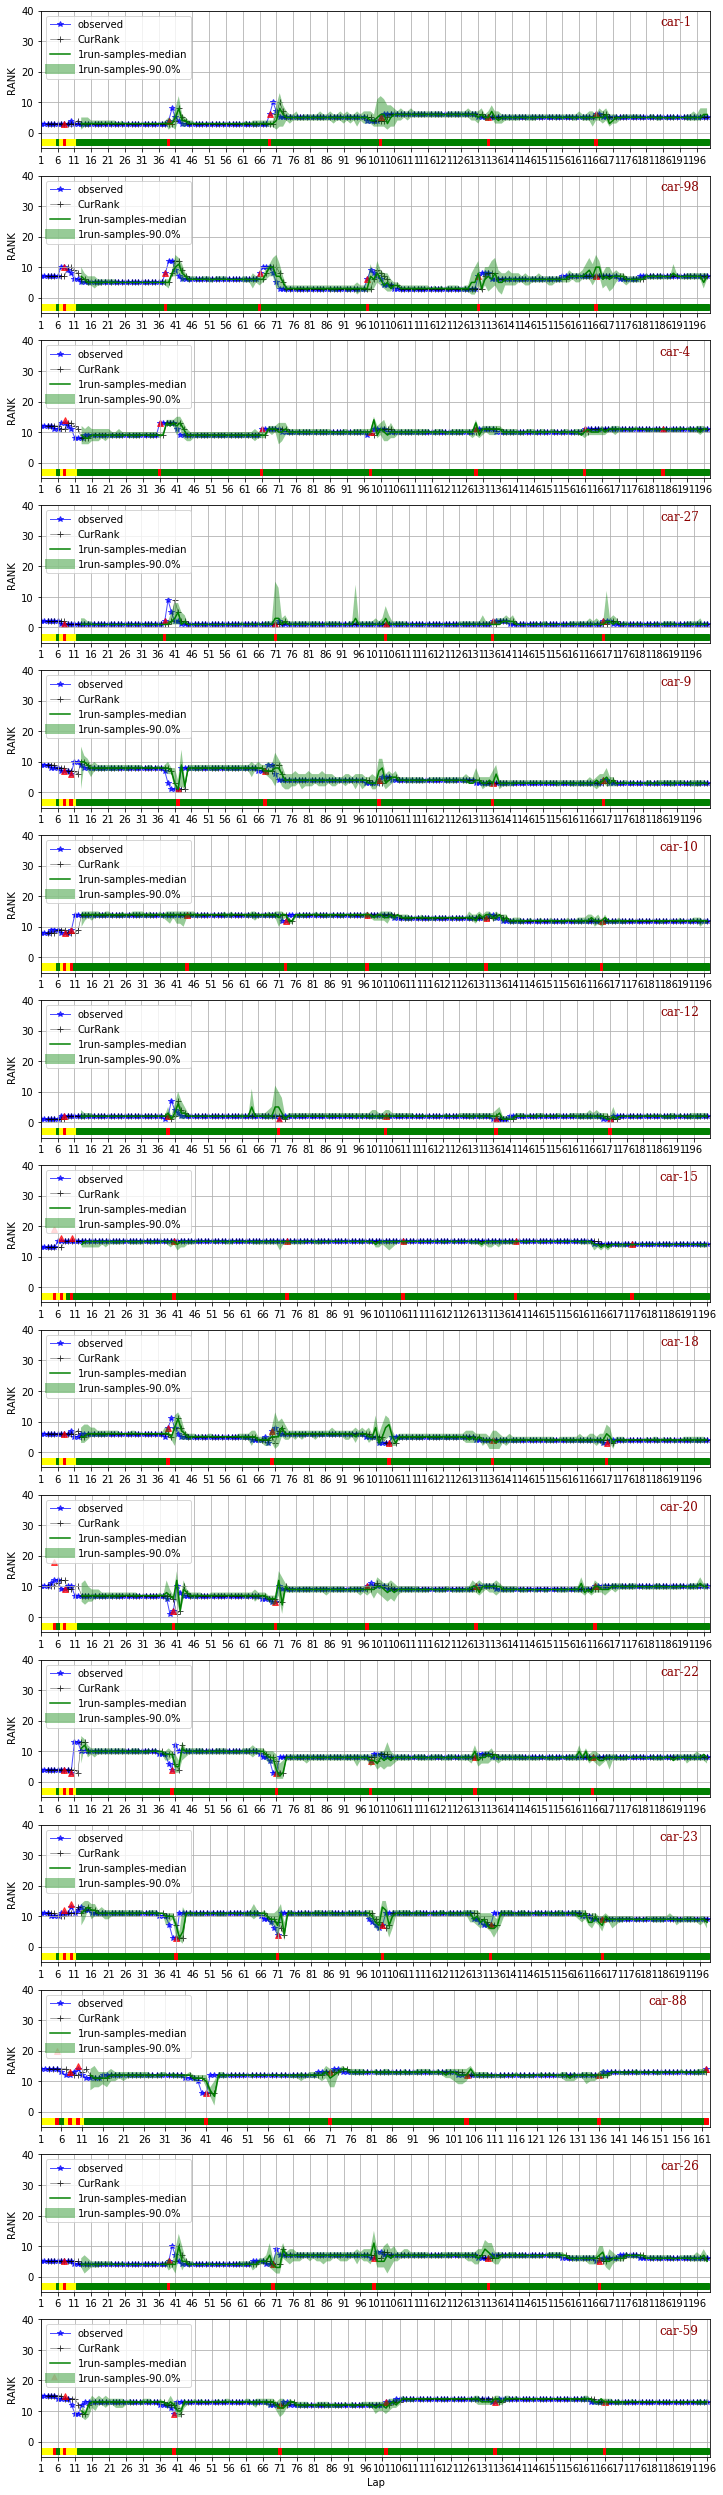

In [3]:
destdir = FORECAST_FIGS_DIR


_alldata, rankdata, _acldata, _flagdata = stagedata[_test_event]

#set gobal variable
gvar.rankdata = rankdata
#destdir = outputRoot + 'oracle-forecast-figs/'
os.makedirs(destdir, exist_ok=True)

#for carno in alldata:
#    plotoracle(alldata, carno, destdir)

#draw summary result
outputfile = destdir + '/allcars'
plotallcars(alldata, outputfile, drawid = 0)

In [4]:
outputRoot

'QuickTestOutput/weighted-noinlap-S0LTYP0T-nocate-c60-poconotf/'